### FilterNet
A neural network for filtering out gaussian noise from an image introduced by aggressive accelerations on the vehicle carrying the camera. 

In [77]:
import os 
import torch 
import torch.nn as nn 
import numpy as np 
import pandas as pd 
from scipy.spatial.transform import Rotation as R 
import matplotlib.pyplot as plt
from skimage import io, transform 
from PIL import Image    
from torch.utils.data import Dataset, DataLoader 
from torchvision import transforms, utils 
from typing import List, Dict, Tuple 
from tqdm import tqdm 

### Dataset Class and Dataloader

In [ ]:
# Create dataset class 

class VideoDataset(Dataset):
    def __init__(self, path_to_data, augmented=False, num_vids=7, seq_length=5, img_size=256):
        """
        Go through each video folder and build a map from 
        index i in range [0, N], where N is the total number
        of frames in all the videos, to a tuple (j, k), where 
        j is the video number and k the frame index in that 
        video. For reference, the videos are stored in the 
        dataset as:  

        data: 
        - test1: 
          - inputs:
            - bd_poses.csv
            - bd_twists.csv
            - frame0000.png
            - frame0001.png
            - ... 
          - targets: 
            - frame0000.png
            - frame0001.png
            - ... 
        - test2: 
            - ... 
        - ... 
        """ 
        self.img_size = img_size
        self.seq_length = seq_length
        self.augmented = augmented
        self.num_vids = num_vids 
        self.path_to_data = path_to_data 
        self.idx_map: List[Tuple[int, int]] = []
        self.poses: Dict[int, np.ndarray] = {}
        self.twists: Dict[int, np.ndarray] = {} 
        for i in tqdm(range(1, self.num_vids + 1)):
            # Define path to pose 
            pose_path = os.path.join(path_to_data, f'test{i}/inputs/bd_poses.csv')
            twist_path = os.path.join(path_to_data, f'test{i}/inputs/bd_twists.csv')

            # Check that files were opened properly 
            if not os.path.isfile(pose_path):
                raise FileNotFoundError(f"Missing pose file: {pose_path}")
            if not os.path.isfile(twist_path):
                raise FileNotFoundError(f"Missing twist file: {twist_path}")  

            # Get poses 
            self.poses[i] = pd.read_csv(pose_path).to_numpy() 
            self.twists[i] = pd.read_csv(twist_path).to_numpy() 

            # Get number of sequences in this video: num_frames - seq_length + 1 
            num_sequences = self.poses[i].shape[0] - (self.seq_length - 1)  

            # Update index map 
            video_num = [i] * num_sequences 
            frame_idx = list(range(0, num_sequences))
            self.idx_map.extend(list(zip(video_num, frame_idx)))

        self.total_num_sequences = len(self.idx_map)

    def __len__(self): 
        """
        Return length of dataset as computed in __init__() function. 
        """
        return self.total_num_sequences 
    
    def __getitem__(self, idx): 
        """ 
        Use map built in __init__() to retrieve the image, 
        pose, and twist directly from the dataset. 
        This avoids loading the entire dataset which 
        overwhelms RAM. 
        """
        assert idx < self.total_num_sequences 
        if torch.is_tensor(idx): 
            idx = idx.tolist() 

        seq_start = True 
        for i in range(self.seq_length):
            # Define path to data 
            test_idx, frame_idx = self.idx_map[idx]
            frame_idx += i
            padded_frame_idx = self.to_zero_pad_idx(frame_idx) 
            input_img_path = os.path.join(self.path_to_data,
                                    f'test{test_idx}/inputs/frame{padded_frame_idx}.png')
            output_img_path = os.path.join(self.path_to_data,
                                    f'test{test_idx}/targets/frame{padded_frame_idx}.png')

            # Load and process data 
            input_frame = io.imread(input_img_path)        
            output_frame = io.imread(output_img_path)        
            input_frame = torch.from_numpy(self.to_grayscale(input_frame)).float() 
            output_frame = torch.from_numpy(self.to_grayscale(output_frame)).float() 
            pose = self.poses[test_idx][frame_idx]
            pose = torch.from_numpy(self.pose_vector_from_matrix(pose).reshape(-1, 1)).float()
            twist = torch.from_numpy(self.twists[test_idx][frame_idx].reshape(-1, 1)).float()
            state = torch.cat((pose, twist), dim=0).view(-1)

            # Resize frames 
            h, w = self.img_size, self.img_size
            resize_frame = transforms.Resize((h, w))
            output_frame = resize_frame(output_frame.unsqueeze(0))
            input_frame = resize_frame(input_frame.unsqueeze(0))

            # Initialize sequence
            if seq_start: 
                in_frame_seq = torch.zeros_like(input_frame).view(1, 1, h, w).expand((self.seq_length, 1, h, w))
                out_frame_seq = torch.zeros_like(output_frame).view(1, 1, h, w).expand((self.seq_length, 1, h, w))
                state_seq = torch.zeros_like(state).unsqueeze(0).expand((self.seq_length, state.shape[0])) 


            # Update sequence
            in_frame_seq[i] = input_frame.view(1, h, w)
            out_frame_seq[i] = output_frame.view(1, h, w) 
            state_seq[i] = state     

            print(f"\nTest index, frame_index: {test_idx, frame_idx}")

            # If we want a broadcasted frame, pose, twist tensor of shape (B, T, 1, H, W, 14)
            if self.augmented: 
                expanded_frame = input_frame.view(1, h, w, 1) 
                expanded_state = state.view(1, 1, 1, -1).repeat(1, h, w, 1)
                augmented_frame = torch.cat((expanded_frame, expanded_state), dim=-1)

                # Initialize augmented sequence 
                if seq_start:
                    aug_seq_in = torch.zeros_like(augmented_frame).unsqueeze(0).expand((self.seq_length, 1, h, w, -1))
                    aug_seq_out = torch.zeros_like(output_frame).unsqueeze(0).expand((self.seq_length, 1, h, w))
                    seq_start = False 

                # Update augmented sequence
                aug_seq_in[i] = augmented_frame
                aug_seq_out[i] = output_frame

        return {'input': (in_frame_seq, state_seq), 'target': out_frame_seq} if not self.augmented else {'input': aug_seq_in, 'target': aug_seq_out}

    def to_zero_pad_idx(self, idx):
        """ 
        Convert frame index from regular index to zero-padded index. 
        e.g. 1 -> 00001, 12 -> 00012 
        """
        return f'{idx:05d}'

    def pose_vector_from_matrix(self, pose): 
        """
        Convert 4x4 pose matrix (as a flattenned length 16 vector) into a position and quaternion length 7 vector. 
        """
        pose = pose.reshape(4, 4) 
        position = pose[:3, 3].reshape(3, 1) 
        orientation = pose[:3, :3]

        quat = R.from_matrix(orientation).as_quat().reshape(-1, 1) 
        norm_quat = quat / np.linalg.norm(quat) 

        return np.vstack((position, norm_quat)).reshape(-1)

    def to_grayscale(self, image):
        """ 
        Convert PNG image to grayscale mask 
        """ 
        #TODO: Try float16 type 
        return (image[..., 0] > 127).astype(np.float32)
        

        

In [142]:
# Make dataloader and load data 
path_to_data = '/home/jrached/cv_project_code/project/data/filter_net/processed_flow'
augmented = False
batch_size = 1
seq_length = 5
img_size = 256
dataset = VideoDataset(path_to_data, augmented=augmented, num_vids=3, seq_length=seq_length, img_size=img_size)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0) #NOTE: num_workers is the number of extra processes running in parallel retrieving the data


100%|██████████| 3/3 [00:00<00:00, 135.51it/s]


### Image and State Encoders and Decoders

In [138]:
# Use transforms to resize images 
# This is an example, but it must actually be performed before feeding image data to encoder
# For the augmented tensor the image is already resized inside the dataloader

sequence = next(iter(loader)) 
if augmented: 
    input, target = sequence['input'], sequence['target']
    print(f'Tensor shape should be: [{batch_size, seq_length, 1, img_size, img_size, 14}] and is: {input.shape}')
else: 

    features = sequence
    image = features['input'][0]
    # transform = transforms.Resize((img_size, img_size))
    # resized_img = transform(image)
    # resized_img.shape
    input, target = features['input'], features['target']
    print(f'\nBatched image shape should be: [{batch_size, seq_length, 1, img_size, img_size}] and is: {image.shape}')




Test index, frame_index: (1, 0)

Test index, frame_index: (1, 1)

Test index, frame_index: (1, 2)

Test index, frame_index: (1, 3)

Test index, frame_index: (1, 4)

Test index, frame_index: (1, 1)

Test index, frame_index: (1, 2)

Test index, frame_index: (1, 3)

Test index, frame_index: (1, 4)

Test index, frame_index: (1, 5)

Test index, frame_index: (1, 2)

Test index, frame_index: (1, 3)

Test index, frame_index: (1, 4)

Test index, frame_index: (1, 5)

Test index, frame_index: (1, 6)

Test index, frame_index: (1, 3)

Test index, frame_index: (1, 4)

Test index, frame_index: (1, 5)

Test index, frame_index: (1, 6)

Test index, frame_index: (1, 7)

Batched image shape should be: [(4, 5, 1, 256, 256)] and is: torch.Size([4, 5, 1, 256, 256])


In [ ]:
# Write classes for compression networks 

#TODO: Try a conv3d encoder. conv3d layers encode temporal information. (Alternative to LSTM). An alternative to the current pipeline would 
# be to use the augmented data tensor (without compressing it) and a conv3d layer to process the (T, B, 1, H, W, 14) input. Which would need to be 
#reshaped to (B, 1, T, H, W, 14). I wouldn't know what to do with the state dimension. Treat them as channels (image, pose, twist)? Flatten them with the sequence dim?   

class ImgEncoder(nn.Module): 
    def __init__(self, in_channel=1, hidden_channel=16, out_channel=32, h_in=256, out_dim=1024):
        """
        Define convolutional neural network architecture for compressing a 256 x 256 image into a 1024 embedding vector.
        Assumes image is square.
        """
        super().__init__()

        # Compute image shape after convolution 
        stride = 2
        padding_one, padding_two = 7, 1
        num_ker_one, num_ker_two = 16, 4
        h_out = (h_in + 2 * padding_one - num_ker_one) // stride + 1 
        h_out = (h_out + 2 * padding_two - num_ker_two) // stride + 1

        # Define CNN 
        linear_in_dim = out_channel * h_out ** 2 
        linear_out_dim = out_dim
        self.conv_stack = nn.Sequential(
                            nn.Conv2d(in_channel, hidden_channel, num_ker_one, stride=stride, padding=padding_one), # h_in, w_in = (256, 256); h_out, w_out = (128, 128)
                            nn.ReLU(),
                            nn.Conv2d(hidden_channel, out_channel, num_ker_two, stride=stride, padding=padding_two), # h_in, w_in = (128, 128); h_out, w_out = (64, 64) 
                            nn.ReLU(), 
                            nn.Flatten(start_dim=1, end_dim=-1), # Flattens (c_out, h_out, w_out) = (32, 64, 64) into 131072
                            nn.Linear(linear_in_dim, linear_out_dim) # Encodes the 131072 length flattened convolved image into a 1024 length embedding vector
        ) 

    def forward(self, x): 
        """
        Define neural network forward pass 
        Input has shape (T, B, 1, H, W)
        """
        seq_len, batch_size, _, h, w = x.shape 
        x = x.view(seq_len * batch_size, 1, h, w)
        return self.conv_stack(x).view(seq_len, batch_size, -1) 
    

class StateEncoder(nn.Module): 
    def __init__(self, in_dim=13, out_dim=128): 
        """
        Define linear layer to generate a length 128 embedding vector from length 13 pose and twist vector. 
        """
        super().__init__()
        self.linear_layer = nn.Linear(in_dim, out_dim)

    def forward(self, x): 
        """ 
        Define nueral network forward pass 
        """
        return self.linear_layer(x) 
    
class ImgDecoder(nn.Module):
    def __init__(self):
        """ 
        TODO: Implement.
        Reconstructs the image from the embedding vector.
        Jialin will write this. 
        """
        pass 

    def forward(self, x): 
        """ 
        TODO: Implement 
        """
        pass 


In [104]:
# Test conv encoder 
mock_img_data = torch.zeros((5, 64, 1, 256, 256))
img_encoder = ImgEncoder() 
img_embedding = img_encoder(mock_img_data)

# Test state encoder 
mock_state_data = torch.zeros((5,64, 13))
state_encoder = StateEncoder()
state_embedding = state_encoder(mock_state_data)


In [105]:
img_embedding.shape
# state_embedding.shape

torch.Size([5, 64, 1024])

### LSTM 

LSTM class with image and state embeddings 
Add Jialin's module here


In [90]:
# Vanilla LSTM 
class LSTM(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__() 
        self.model = nn.LSTM(in_dim, hidden_dim) 
    
    def forward(self, x):
        return self.model(x) 
    
# Jialin's LSTM 

In [ ]:
# Define LSTM class 
class FilterNet(nn.Module):
    def __init__(self, in_dim=1152, hidden_dim=512, seq_length=5, augmented=False):
        """
        Define LSTM architecture with image and state encoders
        Must concatenate image and state embeddings to make a 1024 + 128 length embedding vector for lstm 
        lstm input dimension is then 1024 + 128 = 1152 
        """
        super().__init__()

        # Parameters
        self.in_dim = in_dim 
        self.hidden_dim = hidden_dim 
        self.seq_len = seq_length
        self.augmented = augmented

        # Modules 
        self.flatten = nn.Flatten(start_dim=1)
        self.image_encoder = ImgEncoder()
        self.state_encoder = StateEncoder() 
        self.lstm = LSTM(in_dim, hidden_dim) 
        self.image_decoder = ImgDecoder() 
        self.loss_fun = nn.MSELoss()

    def loss(self, sequence): 
        """
        Unless using the augmented (B, T, 1, H, W, 14) tensor, data will come in as a Tuple storing a sequence of {'input', 'target'}
        dictionaries. Each 'input' field contains a frame, a pose, and a twist, each as a tensor. 

        Must loop through the sequence to generate embedding, but for small sequence lengths, the overhead is negligible, and actually 
        preferable, than the memory overhead of the augmented tensor. 
        """

        if self.augmented: 
            # Retrieve data 
            input, output = sequence['input'].permute(1, 0, 2, 3, 4, 5), sequence['output'].permute(1, 0, 2, 3, 4) # switch to sequence first 
            seq_len, batch_size, _, h, w, _ = input.shape 
            frames = input[..., 0].view(batch_size * seq_len, 1, h, w) # Flatten to feed to conv net
            state = input[:, :, :, 0, 0, 1:]
            out_frame = output[0, ...]

            # Compute embeddings 
            img_embedding = self.image_encoder(frames).view(seq_len, batch_size, 1, h, w)
            state_embedding = self.state_encoder(state)
            compressed_input = torch.cat((img_embedding, state_embedding), dim=-1) 

        else: 
            # Pass each element of the sequence through the model
            batch_size, _, _, _ = sequence[0]['input'][0].shape
            compressed_input = torch.zeros((self.seq_len, batch_size, self.in_dim)) 
            for i, datapoint in enumerate(sequence):
                in_frame = datapoint['input'][0]
                in_pose = datapoint['input'][1]
                in_twist = datapoint['input'][2]
                in_state = torch.cat((in_pose, in_twist), dim=-1)
                out_frame = datapoint['target']

                # Pass inputs through encoders 
                img_embedding = self.image_encoder(in_frame) # out dim should be (B, d_img_emb)
                state_embedding = self.state_encoder(in_state) # out dim should be (B, d_state_emb)

                # Concatenate embedding vector and reconstruct sequence as a tensor 
                compressed_input[i] = torch.cat((img_embedding, state_embedding), dim=-1) 

        # Pass compressed sequence through LSTM 
        lstm_out = self.lstm(compressed_input) # should have shape (T, B, hidden_dim)

        # Transpose and flatten output so it has shape (B, hidden_dim * T) 
        lstm_out = self.flatten(lstm_out.permute(1, 2, 0)) 

        # Pass through decoder to reconstruct the last image in the sequence
        pred_frame = self.image_decoder(lstm_out)
        
        # Get loss between predicted frame and last frame in target sequence
        return self.loss_fun(pred_frame, out_frame)
        
        



### Traning Loop

In [91]:
# Define training parameters 
num_epochs = 1

# Initialize optimizer
optimizer = None 

# Split into train and val loader 
train_loader = None 
val_loader = None 

# Initialize model 
model = FilterNet() 


In [ ]:
# Training loop 
for epoch in range(num_epochs):
    for sequence in tqdm(train_loader): 
        loss = model.loss(sequence)
        loss.backward()
        optimizer.step() 

### Testing: 
#### Testing Dataloader

In [143]:
batch_size = 4
counter = 0 
for datapoint in loader:
    # found_one = False
    # features = datapoint['input']
    # labels = datapoint['target']
    if counter > 2600:
        break
    counter += 1
    # for i in range(batch_size):
    #     image = features[0][i] 
    #     if counter > 1502:
    #         found_one = True
    #         break
    #     counter += 1
    
    # if found_one: 
    #     break

# counter
# len(datapoint)
datapoint['input'][1]
# datapoint['input'][:, 0, :, :, :, 1]
# counter


Test index, frame_index: (1, 0)

Test index, frame_index: (1, 1)

Test index, frame_index: (1, 2)

Test index, frame_index: (1, 3)

Test index, frame_index: (1, 4)

Test index, frame_index: (1, 1)

Test index, frame_index: (1, 2)

Test index, frame_index: (1, 3)

Test index, frame_index: (1, 4)

Test index, frame_index: (1, 5)

Test index, frame_index: (1, 2)

Test index, frame_index: (1, 3)

Test index, frame_index: (1, 4)

Test index, frame_index: (1, 5)

Test index, frame_index: (1, 6)

Test index, frame_index: (1, 3)

Test index, frame_index: (1, 4)

Test index, frame_index: (1, 5)

Test index, frame_index: (1, 6)

Test index, frame_index: (1, 7)

Test index, frame_index: (1, 4)

Test index, frame_index: (1, 5)

Test index, frame_index: (1, 6)

Test index, frame_index: (1, 7)

Test index, frame_index: (1, 8)

Test index, frame_index: (1, 5)

Test index, frame_index: (1, 6)

Test index, frame_index: (1, 7)

Test index, frame_index: (1, 8)

Test index, frame_index: (1, 9)

Test inde

tensor([[[-4.3882e+00,  2.3450e-01,  1.1941e+00,  2.3493e-02,  7.0705e-03,
           1.2308e-01,  9.9209e-01,  6.0653e-03, -1.0197e-03,  1.3178e-02,
          -7.4555e-03, -5.6310e-03, -7.5951e-04],
         [-4.3882e+00,  2.3450e-01,  1.1941e+00,  2.3493e-02,  7.0705e-03,
           1.2308e-01,  9.9209e-01,  6.0653e-03, -1.0197e-03,  1.3178e-02,
          -7.4555e-03, -5.6310e-03, -7.5951e-04],
         [-4.3882e+00,  2.3450e-01,  1.1941e+00,  2.3493e-02,  7.0705e-03,
           1.2308e-01,  9.9209e-01,  6.0653e-03, -1.0197e-03,  1.3178e-02,
          -7.4555e-03, -5.6310e-03, -7.5951e-04],
         [-4.3882e+00,  2.3450e-01,  1.1941e+00,  2.3493e-02,  7.0705e-03,
           1.2308e-01,  9.9209e-01,  6.0653e-03, -1.0197e-03,  1.3178e-02,
          -7.4555e-03, -5.6310e-03, -7.5951e-04],
         [-4.3882e+00,  2.3450e-01,  1.1941e+00,  2.3493e-02,  7.0705e-03,
           1.2308e-01,  9.9209e-01,  6.0653e-03, -1.0197e-03,  1.3178e-02,
          -7.4555e-03, -5.6310e-03, -7.5951e-04]]]

In [73]:
features[0].shape
counter

1503

In [ ]:
pose = features[1]
pose[28]

tensor([-1.3603,  0.6753,  2.2040,  0.0300,  0.0131,  0.1257,  0.9915])

#### Testing interpolated twist

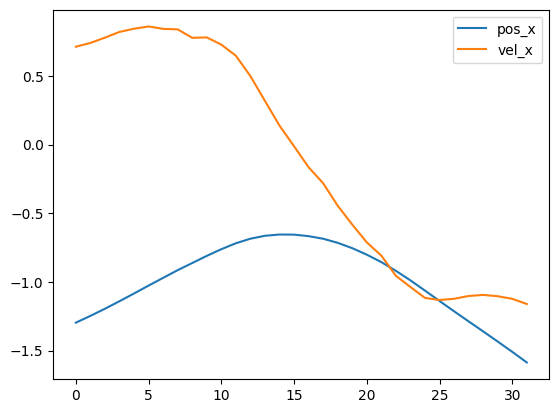

In [ ]:
features[1]
twist = features[2]

plt.plot(pose[:, 0])
plt.plot(twist[:, 0])
plt.legend(["pos_x", "vel_x"])
plt.show()

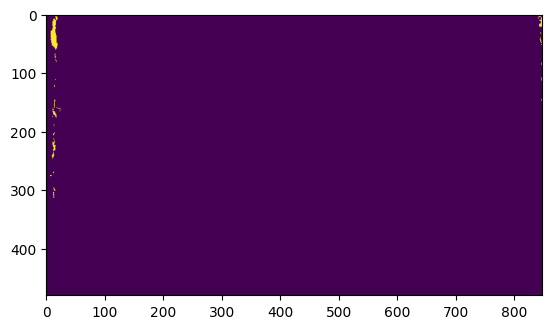

In [67]:
image = features[0][28] 
image.max()
plt.imshow(image)

torch.Size([32, 256, 256])